## <font color=darkblue> Introduction to Transformer Networks and attention-based models</font>

## <font color=darkred> Bibliography & additional ressources </font>

- [1]"A Survey of Diffusion Based Image Generation Models: Issues and Their Solutions", Zhang, T. et al., 2023, https://arxiv.org/abs/2308.13142
``Survey with an overview of theoretical and numerical properties of diffusion-based models``.
- [2] "Denoising Diffusion Probabilistic Models", Ho, J. et al., 2020, https://arxiv.org/abs/2006.11239
- [3] https://yang-song.net/blog/2021/score/
"A very nice blog by one of the most active researcher in diffusion-based models". Most illustrations of this notebook are borrowed from this blog.

We are given a dataset $\{x_1,\ldots,x_N\}$
, where each point is drawn independently from an underlying data distribution. Generative modeling is aims at fitting a model to the data distribution such that we can synthesize new data points.

In **likelihood-based models**, we model directly the probability density function of the data as follows:
$$
p_\theta(x) = \frac{\mathrm{e}^{-f_\theta(x)}}{Z_\theta}\,,
$$
where $f_\theta$ is a real-valued function parameterized by an unknown parameter $\theta$ trained using the dataset. The fact that $Z_\theta$ cannot be computed explicitly is a challenging problem, methods such as Markov Chain Monte Carlo or Sequential Monte Carlo aim at sampling from $p_\theta$ in this setting.

**Score-based approaches**, we model directly the score function:
$$
s_\theta(x) = \nabla_x \log p_\theta(x)\,.
$$
This is appealing since this quantity does not depend on $Z_\theta$ as: $\nabla_x \log p_\theta(x) = - \nabla_x f_\theta(x)$.
The score can therefore be parameterized without worrying about the normalizing constant.

If we train an approximation $\widehat s_\theta$ of $s_\theta$, we can use **Langevin dynamics** to approximately sample from the target distribution as follows. $x_0$ is sampled from any distribution and then, for $k\geq 0$,
$$
x_{k+1} = x_k +\varepsilon \widehat{s}_\theta(x_k) + \sqrt{2\varepsilon}z_{k+1}\,,
$$
where the $(z_k)_{k\geq 1}$ are i.i.d. standard Gaussian vectors.

![](https://yang-song.net/assets/img/score/langevin.gif)

**Question**: how to approximate score function for complex data i.e. images, times series... ?

![](https://yang-song.net/assets/img/score/smld.jpg)

In [1]:
import math
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
mpl.rcParams['lines.linewidth'] = 2

from tqdm import tqdm, trange
import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam, lr_scheduler

## <font color=darkred> Gaussian tools </font>

In [2]:
class gaussian:
    def __init__(self, dimension, mu, sigma):
        self.d = dimension
        self.device = mu.device
        self._mu = mu
        self._sigma = sigma
        self._sq_sigma = torch.linalg.cholesky(self._sigma)
    def mean_covar(self,):
        return self._mu, self._sigma
    def generate_sample(self, size):
        self.sample = self._mu + torch.randn(size, self.d, device=self.device) @ self._sq_sigma.T
        return self.sample
    def to(self, device):
        self.device = device
        self._mu = self._mu.to(device)
        self._sigma = self._sigma.to(device)
        self._sq_sigma = self._sq_sigma.to(device)
        if "sample" in self.__dict__:
            self.sample = self.sample.to(device)

def empirical_mean_covar(sample):
    mean = sample.mean(axis = 0)
    sample_centered = sample - mean
    covar = sample_centered.T @ sample_centered / (sample_centered.shape[0] - 1)
    return mean, covar

class empirical:
    def __init__(self, sample):
        self.sample = sample
    def mean_covar(self):
        return empirical_mean_covar(self.sample)

def kl_divergence(mu1, sigma1, mu2, sigma2):
    d = len(mu1)
    delta_mu = mu2 - mu1
    inverse_sigma2 = torch.pinverse(sigma2)

    log_term = torch.log(torch.det(sigma2) / torch.det(sigma1))
    trace_term = torch.trace(inverse_sigma2 @ sigma1)
    delta_term = delta_mu @ inverse_sigma2 @ delta_mu[:, None]

    return 0.5 * (log_term - d + trace_term + delta_term).item()

def kl(a, b):
    return kl_divergence(*a.mean_covar(), *b.mean_covar())

class explicit_score:
    def __init__(self, sde, dataset):
        self.device = sde.device
        self.mu_0, self.sigma_0 = dataset.mean_covar()
        self.sde = sde
        self.id_d = torch.eye(dataset.d, device=self.device)

    def __call__(self, x, t):
        if len(t) == 1:
            t = torch.full((x.shape[0], 1), t.item(), device=self.device)
        mu_t, sigma_t = self.sde.mu(t), self.sde.sigma(t)
        mat = torch.pinverse((mu_t**2).unsqueeze(-1) * self.sigma_0
                            + (sigma_t**2).unsqueeze(-1) * self.id_d)
        score = -torch.bmm(mat, (x - mu_t * self.mu_0).unsqueeze(-1))
        return score.squeeze(-1)

    def to(self, device):
        self.device = device
        self.mu_0, self.sigma_0 = self.mu_0.to(device), self.sigma_0.to(device)
        self.sde.to(device)
        self.id_d = self.id_d.to(device)



## <font color=darkred> Toy dataset </font>

In [3]:
# Anisotropic Gaussian
d = 5
mu_data = 5 * torch.ones(d)
rho = 0.7
sigma_data = torch.eye(d) * torch.linspace(1, 10, d) + rho * (torch.ones((d,d)) - torch.eye(d))
sq_sigma_data = torch.linalg.cholesky(sigma_data)

In [4]:
dataset = gaussian(d, mu_data, sigma_data)
dataset.generate_sample(10000)

tensor([[ 5.3963,  1.7456,  5.8680,  3.8894,  6.9576],
        [ 5.2171,  4.4251,  2.0479,  4.8862,  0.5479],
        [ 5.1255,  6.2143,  2.2547,  2.8947, 11.9150],
        ...,
        [ 5.1443,  6.3386,  5.6876, 10.9736,  5.3585],
        [ 4.5636,  2.1520,  3.2770,  3.7689,  7.6919],
        [ 4.9989,  4.7846,  3.6569,  8.5631,  8.4848]])

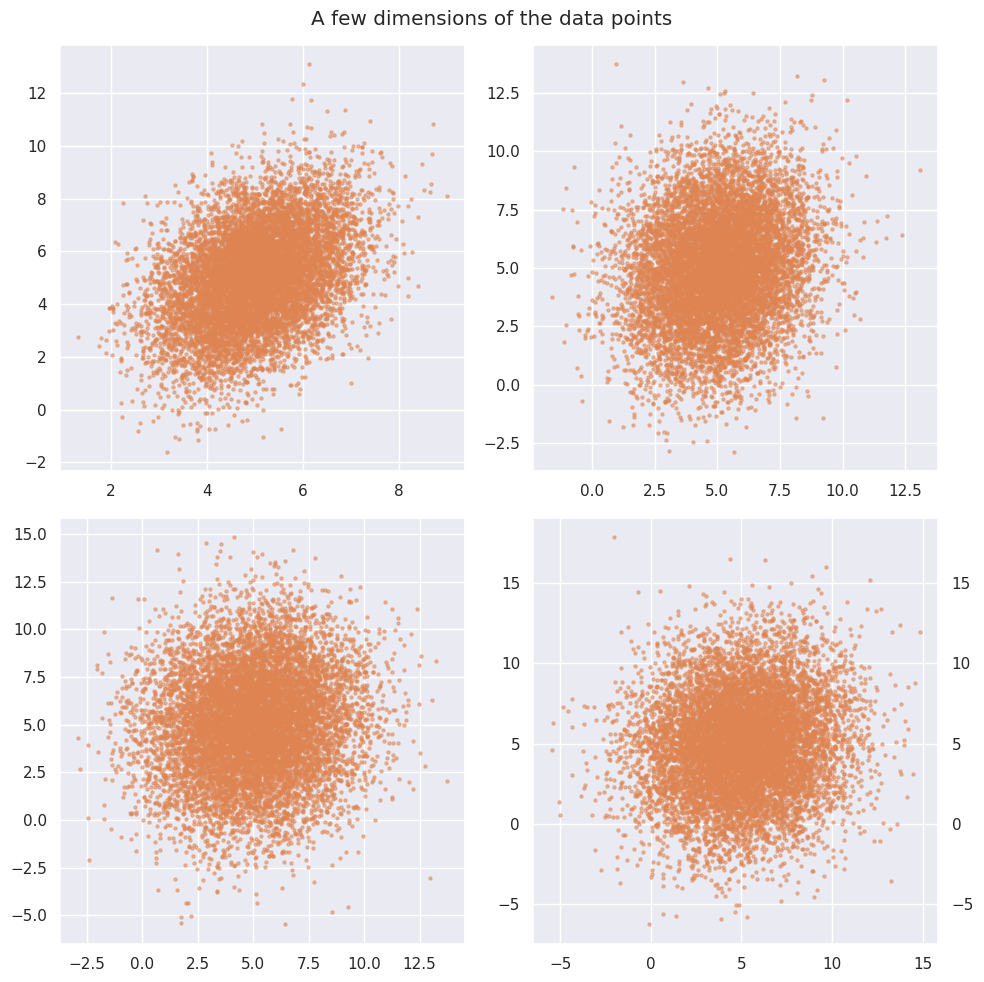

In [5]:
x0 = dataset.sample
fig, axs = plt.subplots(ncols=2, nrows=2, layout = "tight", figsize=(10, 10))
axs[0,0].scatter(x0[:,0], x0[:,1], c='C1', s=5, alpha=0.5)
axs[0,1].scatter(x0[:,1], x0[:,2], c='C1', s=5, alpha=0.5)
axs[1,0].scatter(x0[:,2], x0[:,3], c='C1', s=5, alpha=0.5)
axs[1,1].scatter(x0[:,3], x0[:,4], c='C1', s=5, alpha=0.5)
fig.suptitle("A few dimensions of the data points")
plt.tick_params(labelright=True)
plt.grid('True')
plt.show;

## <font color=darkred> Forward diffusion </font>

#### Rationale

![](https://yang-song.net/assets/img/score/sde_schematic.jpg)

We consider
\begin{equation*}
    \mathrm{d} X_t = - \alpha(t) X_t \mathrm{d} t+ \eta(t) \mathrm{d} W_t, \qquad X_0 \sim p_{\mathrm{data}}\,,
\end{equation*}
where $(W_t)_{t \in [0,T]}$ is a standard $d$-dimensional Brownian motion, and $\alpha,\eta: [0,T] \to (0, +\infty)$.



In practice, we sample $X_0\sim p_{\mathrm{data}}$ and we produce **noisy versions** $X_{t_i}$, $1\leq i \leq n$ of $X_0$ by:
$$
X_{t_{i+1}} = X_{t_i} + \int_{t_i}^{t_{i+1}}\left(- \alpha(t) X_t \operatorname{d}\! t+ \eta(t) \operatorname{d}\! W_t\right)
$$

A standard case is the **time-homogeneous Ornstein-Uhlenbeck** setting:
\begin{equation*}
    \alpha(t) = \alpha > 0, \quad \eta(t) = \eta > 0, \quad A(t) = \alpha t, \quad
    \sigma(t) = \eta \sqrt{ \frac{1 - e^{-2 \alpha t}}{2 \alpha} }
\end{equation*}

Explicit solution given by for all $t > 0$,
\begin{equation*}
    X_t = e^{-\alpha t} X_0 + e^{-\alpha t} \int_0^t e^{\alpha s} \eta \mathrm{d} W_s\,,
\end{equation*}
so that for all $t > 0$,
\begin{equation*}
    X_t \sim \mathcal{N}\big(\mu_t X_0 ; \sigma^2(t) I_d \big) \quad
    \text{with} \quad \mu_t = e^{-\alpha t} \text{ and } \sigma^2(t) = e^{-2 \alpha t} \int_0^t e^{2 \alpha s} \eta^2 \mathrm{d} s = \eta^2 \frac{1-e^{-2 \alpha t}}{2\alpha}\,.
\end{equation*}

The **time-inhomogeneous case** considered by DDPM is given by:
\begin{equation*}
    \alpha(t) = \frac{\beta(t)}{2 \sigma_\infty^2}, \quad \eta(t) = \sqrt{\beta(t)}, \quad A(t) = \frac{1}{2 \sigma_\infty^2} \int_0^t \beta(s) \operatorname{d}\! s, \quad
    \sigma(t) = \sigma_\infty \sqrt{ 1 - e^{- \frac{1}{\sigma_\infty^2} \int_0^t \beta(s) \operatorname{d}\! s} }
\end{equation*}

#### Tools for the forward SDE

We consider in the following case a setting where $\alpha$ is a linear function.

In [9]:
class forward_sde:
    def __init__(self, dimension, final_time, sigma_infty, device=torch.device('cpu')):
        self.d = dimension
        self.final_time = final_time
        self.sigma_infty = sigma_infty
        self.final = gaussian(dimension,
                              torch.zeros(dimension),
                              self.sigma_infty**2 * torch.eye(dimension))
        self.device = device
    def to(self, device):
        self.device = device
        self.final.to(device)

class forward_OU(forward_sde):
    def __init__(self, dimension, alpha, eta, final_time):
        forward_sde.__init__(self, dimension, final_time, sigma_infty=eta / math.sqrt(2*alpha))
        self._alpha = alpha
        self._eta = eta
    def alpha(self, time_t):
        return self._alpha
    def eta(self, time_t):
        return self._eta
    def alpha_integrate(self, time_t):
        return self._alpha * time_t
    def sigma(self, time_t):
        return self._eta * torch.sqrt((1. - torch.exp(- 2*self._alpha * time_t)) / (2*self._alpha))
    def mu(self, time_t):
        return torch.exp(-self.alpha_integrate(time_t))


class forward_DDPM(forward_sde):
    def __init__(self, dimension, beta, sigma_infty, final_time):
        forward_sde.__init__(self, dimension, final_time, sigma_infty)
        self.beta = beta
        self.sigma_infty = sigma_infty
    def alpha(self, time_t):
        return self.beta(time_t) / (2 * self.sigma_infty**2)
    def eta(self, time_t):
        return torch.sqrt(self.beta(time_t))
    def alpha_integrate(self, time_t):
        return self.beta.integrate(time_t) / (2 * self.sigma_infty**2)
    def sigma(self, time_t):
        return self.sigma_infty * torch.sqrt(1. - torch.exp(- 2*self.alpha_integrate(time_t)))
    def mu(self, time_t):
        return torch.exp(-self.alpha_integrate(time_t))


class beta_parametric:
    def __init__(self, final_time, beta_min, beta_max):
        self.final_time = final_time
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.delta = (beta_max - beta_min) / final_time

    def __call__(self, t):
        return self.beta_min + self.delta * t

    def integrate(self, t):
        return self.beta_min * t + 0.5 * self.delta * t**2

    #def change_a(self, a):
    #    self.a = a
    #    if a == 0:
    #        self.delta = (self.beta_max - self.beta_min) / self.final_time
    #    else:
    #        self.delta = (self.beta_max - self.beta_min) / (math.exp(self.a * self.final_time) - 1.)



#### Sampling noise-perturbed data points

In [10]:
sigma_infty = 1
beta_min = 0.1
beta_max = 20
T = 1
beta = beta_parametric(T, beta_min, beta_max)

In [11]:
sde = forward_DDPM(d, beta, sigma_infty, T)

In [12]:
def generate(sde, x0, time_tau):
    mean = sde.mu(time_tau) * x0
    noise = sde.sigma(time_tau) * torch.randn_like(x0)
    return mean + noise, noise

In [13]:
x0 = dataset.sample
xT, _ = generate(sde, x0, torch.tensor([T]))
empirical(xT).mean_covar()

(tensor([0.0430, 0.0460, 0.0499, 0.0341, 0.0232]),
 tensor([[ 1.0180e+00, -5.6981e-03, -5.5796e-03, -4.3649e-03,  4.1145e-03],
         [-5.6981e-03,  1.0032e+00, -4.6243e-03,  6.4106e-03,  8.1102e-04],
         [-5.5796e-03, -4.6243e-03,  1.0110e+00,  6.8806e-03, -3.6231e-03],
         [-4.3649e-03,  6.4106e-03,  6.8806e-03,  9.9454e-01,  2.3429e-02],
         [ 4.1145e-03,  8.1102e-04, -3.6231e-03,  2.3429e-02,  9.9305e-01]]))

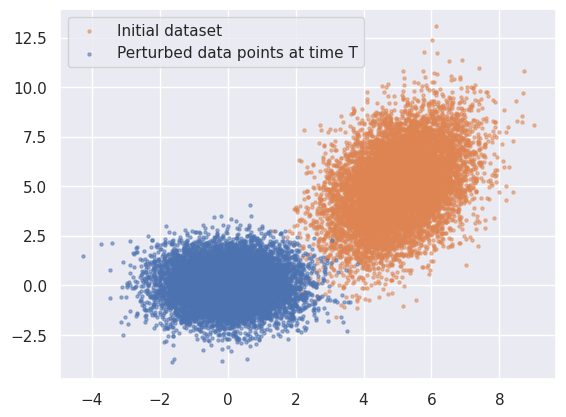

In [14]:
plt.scatter(x0[:,0], x0[:,1], c='C1', s=5, alpha=0.5, label = "Initial dataset")
KL_init = kl(dataset, sde.final)

xT, _ = generate(sde, x0, torch.tensor([T]))
plt.scatter(xT[:,0], xT[:,1], s=5, alpha=0.5, label = "Perturbed data points at time T")
KL_transformed = kl(empirical(xT), sde.final)

plt.legend();

KL distance between initial data and standard Gaussian:

In [ ]:
KL_init

70.3837890625

KL distance between transformed data and standard Gaussian:

In [ ]:
KL_transformed

0.0036330905277282

## <font color=darkred> Backward diffusion </font>

#### Rationale

The forward SDE can be written as: $X_0\sim p_{\mathrm{data}}$ and
$$
dX_t = f(t,X_t)dt + g(t)dW_t\,.
$$

Let $p_t$ be the (marginal) probability density function of $X_t$. Note that $p_0 = p_{\mathrm{data}}$ and $p_T$ is close to the stationary distribution of the forward process $\pi$ (easy to sample from).

We can associate with the forward SDE a backward SDE evolving backwards in time so that $X_T\sim \pi$ and
$$
dX_t = (-f(t,X_t) + g^2(t)\nabla \log p_t(X_t))dt + g(t)dW_t\,.
$$

In order to estimate $\nabla \log p_t(X_t)$, we train a time-dependent score-based model $s_\theta(t,X_t)$.

#### Euler scheme

Euler scheme, with step size $h = \frac{T}{N}$, $t_n = n h$,
\begin{equation*}
    \bar X_{t_{n+1}}^h = \bar X_{t_n}^h + \big(\alpha(T-t_n \big) \bar X_{t_n}^h + \eta^2(T-t_n) \mathbf{s}(T-t_n, \bar X_{t_n}^h) \big) h + \eta(T-t_n) \sqrt{h} G_{n+1}
\end{equation*}

In [15]:
def backward_euler(init, sde, score_theta, num_steps):
    x_bar = init.clone()
    step_size = sde.final_time / num_steps
    with torch.no_grad():
        time_T = torch.tensor([sde.final_time], dtype=init.dtype, device=init.device)
        for n in range(1, num_steps+1):
            rev_tn = time_T - n * step_size
            drift = sde.alpha(rev_tn) * x_bar + sde.eta(rev_tn)**2 * score_theta(x_bar, rev_tn)
            noise = sde.eta(rev_tn) * math.sqrt(step_size) * torch.randn_like(init)
            x_bar += drift * step_size + noise
    return x_bar

#### Backward simulation when the score is known

In [16]:
class explicit_score:
    def __init__(self, sde, dataset):
        self.mu_0, self.sigma_0 = dataset.mean_covar()
        self.sde = sde
        self.id_d = torch.eye(d)

    def __call__(self, x, t):
        if len(t) == 1:
            t = torch.full((x.shape[0], 1), t.item(), device=self.sde.device)
        mu_t, sigma_t = self.sde.mu(t), self.sde.sigma(t)
        mat = torch.inverse((mu_t**2).unsqueeze(-1) * self.sigma_0
                            + (sigma_t**2).unsqueeze(-1) * self.id_d)
        score = -torch.bmm(mat, (x - mu_t * self.mu_0).unsqueeze(-1))
        return score.squeeze(-1)

    def to(self, device):
        self.mu_0, self.sigma_0 = self.mu_0.to(device), self.sigma_0.to(device)
        self.sde.to(device)
        self.id_d = self.id_d.to(device)

In [17]:
score_theta = explicit_score(sde, dataset)

init = sde.final.generate_sample(10000)
num_steps = 50

xbarT_euler = backward_euler(init, sde, score_theta, num_steps)

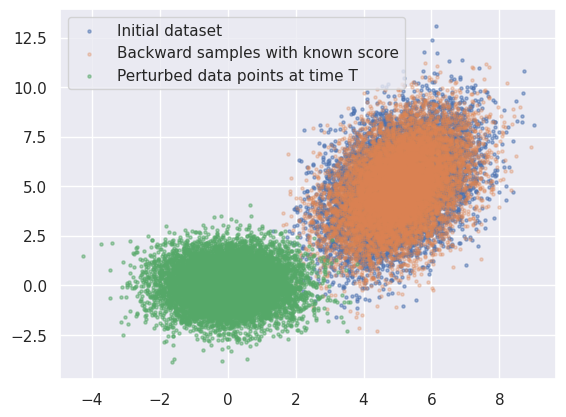

In [18]:
plt.scatter(x0[:,0], x0[:,1], s=5, alpha=0.5, label = "Initial dataset")
plt.scatter(xbarT_euler[:,0], xbarT_euler[:,1], s=5, alpha=0.3, label = "Backward samples with known score")
plt.scatter(xT[:,0], xT[:,1], s=5, alpha=0.5, label = "Perturbed data points at time T")
plt.legend();
KL = kl(empirical(xbarT_euler), dataset)

KL distance between initial data points and backward samples:

In [19]:
KL

0.003111570607870817

#### Tools for the backward SDE

In [21]:
def backward_euler(init, sde, score_theta, num_steps):
    x_bar = init.clone()
    step_size = sde.final_time / num_steps
    with torch.no_grad():
        time_T = torch.tensor([sde.final_time], dtype=init.dtype, device=init.device)
        for n in range(1, num_steps+1):
            rev_tn = time_T - n * step_size
            drift = sde.alpha(rev_tn) * x_bar + sde.eta(rev_tn)**2 * score_theta(x_bar, rev_tn)
            noise = sde.eta(rev_tn) * math.sqrt(step_size) * torch.randn_like(init)
            x_bar += drift * step_size + noise
    return x_bar

## <font color=darkred> Sampling with a trained score </font>

#### Rationale and loss function

A natural training objective
 is given by a continuous weighted combination of Fisher divergences
 $$
\mathcal{L}(\theta) = \mathbb{E}_{U\sim U(0,T), X_t}\left[\lambda(t)\left\|s_\theta(t,X_t) - \nabla \log p_t(X_t)\right\|^2\right]\,.
 $$
 However, $\nabla \log p_t$ is unknown and this loss cannot be computed.

We can replace in the previous loss, the score of the marginal distribution by the score of the conditional distribution given $X_0$ which is known. This yields:

\begin{equation*}
    \mathcal{L}(\theta) = \int_0^T \lambda(t)
    \mathbf{E} \bigg[ \Big| s_\theta(t, X_t) - \frac{e^{-A(t)} X_0 - X_t}{\sigma_t^2} \Big|^2 \bigg] \operatorname{d}\! t
\end{equation*}

\begin{equation*}
    \mathcal{L}(\theta) = \int_0^T \frac{\lambda(t)}{\sigma^2_t}
    \mathbf{E} \bigg[ \Big| \sigma^2_t s_\theta(t, X_t) - \big(e^{-A(t)} X_0 - X_t\big)\Big|^2 \bigg] \operatorname{d}\! t
\end{equation*}

Using $\lambda(t) = \sigma^2_t$ we get
\begin{equation*}
    \mathcal{L}(\theta) = \mathbf{E} \bigg[ \Big| \sigma^2_\tau s_\theta(\tau, X_\tau) - \big( e^{-A(\tau)} X_0 - X_\tau \big) \Big|^2 \bigg]
\end{equation*}
where $\tau \sim \mathcal{U}([0,T])$ independant of $X$.


In [22]:
import math
import torch
import torch.nn as nn
from torch.nn.modules import Linear, Sequential

DEFAULT_DTYPE = torch.float32

def get_timestep_embedding(timesteps, embed_dim: int, dtype: torch.dtype = DEFAULT_DTYPE):
    """
    Adapted from fairseq/fairseq/modules/sinusoidal_positional_embedding.py
    The implementation is slightly different from the decription in Section 3.5 of [1]
    [1] Vaswani, Ashish, et al. "Attention is all you need."
     Advances in neural information processing systems 30 (2017).
    """
    half_dim = embed_dim // 2
    embed = math.log(10000) / (half_dim - 1)
    embed = torch.exp(-torch.arange(half_dim, dtype=dtype, device=timesteps.device) * embed)
    embed = torch.outer(timesteps.ravel().to(dtype), embed)
    embed = torch.cat([torch.sin(embed), torch.cos(embed)], dim=1)
    return embed

DEFAULT_NONLINEARITY = nn.ReLU(inplace=True)

class TemporalLayer(nn.Module):
    nonlinearity = DEFAULT_NONLINEARITY

    def __init__(self, in_features, out_features, temporal_features):
        super(TemporalLayer, self).__init__()
        self.fc1 = Linear(in_features, out_features, bias=False)
        self.enc = Linear(temporal_features, out_features, bias=False)

    def forward(self, x, t_emb):
        out = self.nonlinearity(self.fc1(x) + self.enc(t_emb))
        return out

class Sequential(nn.Sequential):
    def forward(self, input, **kwargs):
        for module in self:
            input = module(input, **kwargs)
        return input

class Decoder(nn.Module):
    nonlinearity = DEFAULT_NONLINEARITY

    def __init__(self, in_features, mid_features, num_temporal_layers):
        super(Decoder, self).__init__()

        self.in_fc = Linear(in_features, mid_features, bias=False)
        self.temp_fc = Sequential(*(
            [TemporalLayer(mid_features, mid_features, mid_features)
            for _ in range(num_temporal_layers) ]))
        self.out_fc = Linear(mid_features, in_features)
        self.t_proj = Linear(mid_features, mid_features, bias=False)
        self.mid_features = mid_features

    def forward(self, x, t):
        t_emb = get_timestep_embedding(t, self.mid_features)
        t_emb = self.t_proj(t_emb)
        out = self.in_fc(x)
        out = self.temp_fc(out, t_emb=t_emb)
        out = self.out_fc(out)
        return out



In [23]:
class loss_conditional:
    def __init__(self, score_theta, sde, eps=1e-5):
        self.score_theta = score_theta
        self.sde = sde
        self.eps = eps
    def __call__(self, x0):
        time_tau = torch.rand((x0.shape[0], 1), device=x0.device) * (self.sde.final_time - self.eps) + self.eps
        x_tau, noise = generate(self.sde, x0, time_tau)
        score = self.sde.sigma(time_tau)**2 * self.score_theta(x_tau, time_tau)
        target = - noise
        loss = torch.mean(torch.sum((score - target)**2, axis=1))
        return loss

In [24]:
def train(loss_fn, dataloader, n_epochs, optimizer):
    tqdm_epoch = trange(n_epochs)
    for epoch in tqdm_epoch:
        avg_loss = 0.
        num_items = 0
        for x0 in dataloader:
            loss = loss_fn(x0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() * x0.shape[0]
            num_items += x0.shape[0]
        tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

#### Training

In [25]:
# network parameters
mid_features = 128
num_layers = 3

# optimisation parameters
n_epochs = 100
learning_rate = 1.0e-3
batch_size = 1024

In [26]:
score_theta = Decoder(sde.d, mid_features, num_layers)
optimizer = Adam(score_theta.parameters(), lr=learning_rate)

loss = loss_conditional(score_theta, sde)

dataloader = DataLoader(dataset.sample, batch_size=batch_size, shuffle=True)
train(loss, dataloader, n_epochs=n_epochs, optimizer=optimizer)

Average Loss: 0.844480: 100%|██████████| 100/100 [00:25<00:00,  3.94it/s]


#### Sampling with the trained model

In [27]:
init = sde.final.generate_sample(10000)
num_steps = 100
sample_euler = backward_euler(init, sde, score_theta, num_steps)

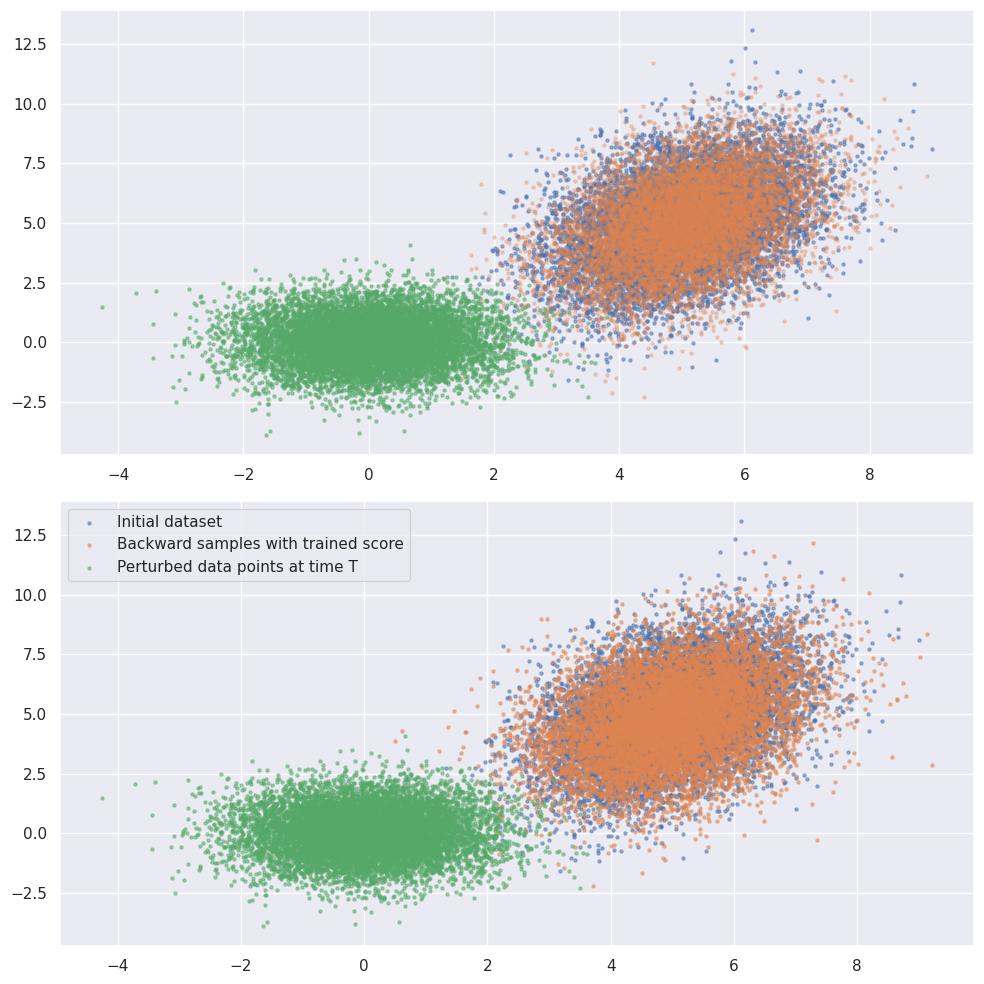

In [28]:
fig, axs = plt.subplots(2,layout = "tight", figsize=(10, 10))
axs[0].scatter(x0[:,0], x0[:,1], s=5, alpha=0.5, label = "Initial dataset")
axs[0].scatter(xbarT_euler[:,0], xbarT_euler[:,1], s=5, alpha=0.3, label = "Backward samples with known score")
axs[0].scatter(xT[:,0], xT[:,1], s=5, alpha=0.5, label = "Perturbed data points at time T")

axs[1].scatter(x0[:,0], x0[:,1], s=5, alpha=0.5, label = "Initial dataset")
axs[1].scatter(sample_euler[:,0], sample_euler[:,1], s=5, alpha=0.5, label = "Backward samples with trained score")
axs[1].scatter(xT[:,0], xT[:,1], s=5, alpha=0.5, label = "Perturbed data points at time T")
plt.legend();
KL = kl(empirical(sample_euler), dataset)